## **RECONOCIMIENTO DE EMOCIONES EN TRINOS: PROCESAMIENTO DE LENGUAJE NATURAL**
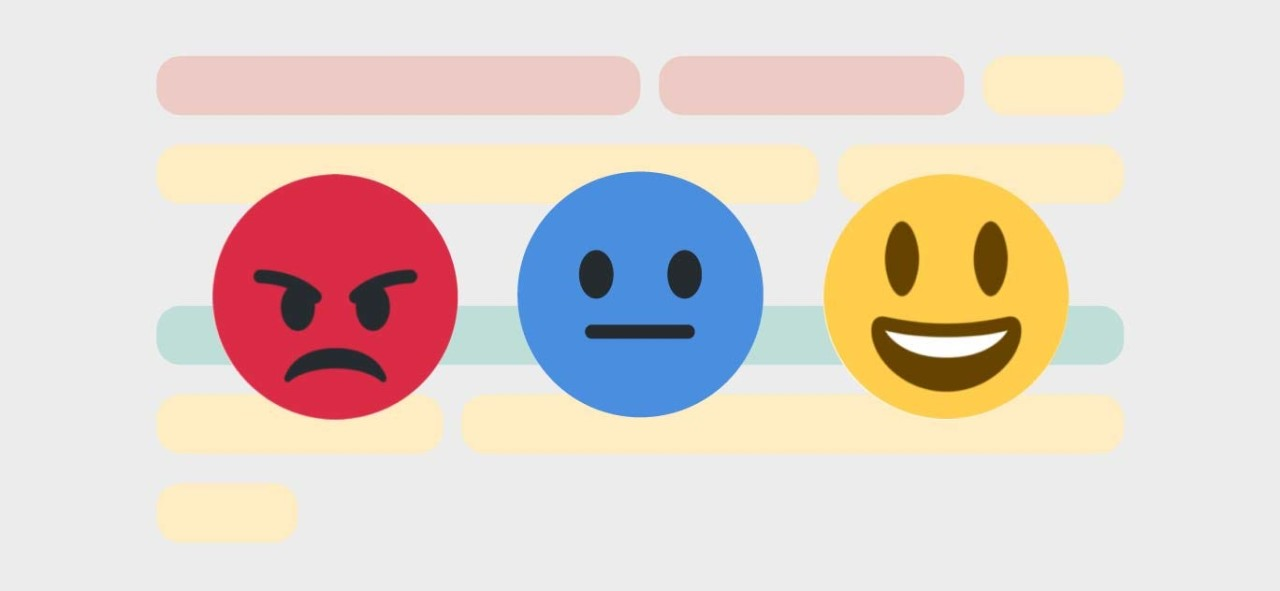
---

## **Dataset:** [Tweet Emotion Dataset](https://github.com/dair-ai/emotion_dataset)

## **Analista:** Gerardo Javier Forero




# **¿QUÉ VAMOS A HACER?**

Este proyecto desarrolla un sistema de inteligencia artificial capaz de identificar y clasificar seis emociones fundamentales (tristeza, alegría, amor, ira, miedo y sorpresa) en tweets en español. Utilizando técnicas avanzadas de procesamiento de lenguaje natural (NLP) y aprendizaje profundo, abordamos el desafío del desbalance de clases mediante estrategias optimizadas de sobremuestreo que permitieron alcanzar un rendimiento global del 89% de exactitud, incluso en emociones minoritarias. Esta tecnología proporciona a profesionales del marketing y comunicación una herramienta valiosa para comprender las respuestas emocionales de los usuarios en redes sociales, detectar tendencias afectivas y optimizar estrategias de engagement basadas en las reacciones emocionales del público objetivo. A través de este notebook, exploraremos todo el proceso: desde la preparación de datos y análisis exploratorio hasta el entrenamiento del modelo y evaluación de resultados con métricas detalladas.



## **ESTRUCTURA E IMPORTACIÓN DE LIBRERÍAS**

Se establece la infraestructura inicial para un análisis de emociones en tweets utilizando aprendizaje profundo. Se comienza instalando e importando bibliotecas esenciales como TensorFlow para construir el modelo, datasets de Hugging Face para cargar datos de emociones, y herramientas de visualización como matplotlib. El código define dos funciones clave: una para visualizar el progreso del entrenamiento mediante gráficas de precisión y pérdida a lo largo del tiempo, permitiéndote detectar problemas como el sobreajuste, y otra para generar matrices de confusión que revelan qué emociones el modelo identifica correctamente y cuáles tiende a confundir. Finalmente, verifica e imprime la versión de TensorFlow en uso, asegurando la compatibilidad técnica del entorno. Toda esta preparación sienta las bases para posteriormente entrenar un modelo capaz de detectar emociones como alegría, tristeza o enojo en textos breves como los tweets.

In [1]:
!pip install datasets
import datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 17.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.0
    Uninstalling fsspec-2025.3.0:
      Successfully uninstalled fsspec-2025.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system 

In [2]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import random


def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()


print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.18.0


## **IMPORTACIÓN Y PREPARACIÓN DE LOS DATOS**

Se importan y preparan los datos emocionales para su análisis. Comienza cargando el dataset de emociones mediante la función load_dataset, que automáticamente descarga una colección de tweets etiquetados con distintas emociones. Luego, separa estos datos en tres conjuntos esenciales: entrenamiento (para que el modelo aprenda), validación (para ajustar el modelo durante el entrenamiento) y prueba (para evaluar el rendimiento final). A continuación, define una función práctica llamada get_tweets que extrae y organiza tanto los textos de los tweets como sus etiquetas emocionales correspondientes, facilitando su manipulación. Al aplicar esta función al conjunto de entrenamiento, el código genera dos listas paralelas: una con los mensajes y otra con sus clasificaciones emocionales. Finalmente, muestra un ejemplo concreto (el segundo tweet del conjunto) junto con su etiqueta, permitiendo visualizar cómo se estructuran estos datos antes de construir el modelo de análisis emocional.

In [3]:
dataset = datasets.load_dataset('emotion')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/9.05k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/127k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/129k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [4]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [5]:
train = dataset['train']
val = dataset['validation']
test = dataset['test']

In [6]:
def get_tweets(data):
    tweets = [x['text'] for x in data]
    labels = [x['label'] for x in data]
    return tweets, labels

In [7]:
tweets, labels = get_tweets(train)

In [8]:
tweets[1], labels[1]

('i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
 0)

## **TOKENIZACIÓN**

Ahora transformamos los tweets en secuencias numéricas que nuestro modelo pueda entender mediante el uso de un tokenizador. Importamos el Tokenizer de Keras y lo configuramos para que maneje las 10,000 palabras más frecuentes, utilizando '<UNK>' como marcador para palabras desconocidas. Entrenamos nuestro tokenizador con el conjunto completo de tweets, lo que nos permite construir un diccionario que asigna un número único a cada palabra según su frecuencia. Como prueba, aplicamos esta conversión al primer tweet y mostramos el resultado, verificando que efectivamente estamos transformando el texto natural en secuencias numéricas. Esta es una etapa crucial en nuestro proceso, ya que los modelos de aprendizaje profundo no pueden procesar texto directamente, sino que necesitan estas representaciones numéricas para detectar patrones emocionales en los tweets.

In [9]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [10]:
tokenizer = Tokenizer(num_words=10000, oov_token='<UNK>')

tokenizer.fit_on_texts(tweets)

print(tokenizer.texts_to_sequences([tweets[0]]))

[[2, 139, 3, 679]]


## **RELLENO Y TRUNCAMIENTO DE SECUENCIAS**

Ahora analizamos la longitud de nuestros tweets para entender mejor sus características. Creamos una lista con el número de palabras de cada tweet y generamos un histograma que nos muestra visualmente su distribución. Esta visualización es crucial para decidir la longitud óptima que usaremos en nuestro modelo. A continuación, importamos la función pad_sequences de Keras y definimos nuestra propia función get_sequences, que convierte los tweets en secuencias numéricas y luego las estandariza a una longitud fija de 50 tokens. Cuando las secuencias son más cortas, las rellenamos con ceros al final (padding='post'), y si son más largas, las recortamos desde el final (truncating='post'). Aplicamos esta función a nuestros tweets de entrenamiento y verificamos el resultado mostrando la primera secuencia procesada. Este paso es fundamental para que nuestro modelo reciba datos de entrada uniformes, permitiéndole enfocarse en identificar patrones emocionales sin preocuparse por las variaciones en la longitud de los textos.

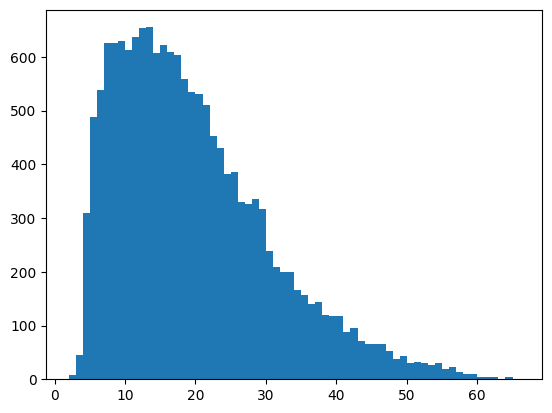

In [11]:
lengths = [len(t.split(' ')) for t in tweets]

plt.hist(lengths, bins=len(set(lengths)))
plt.show()

In [12]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [13]:
def get_sequences(tokenizer, tweets):
    sequences = tokenizer.texts_to_sequences(tweets)
    padded_sequences = pad_sequences(sequences, truncating='post', maxlen=50, padding='post')
    return padded_sequences

In [14]:
padded_train_sequences = get_sequences(tokenizer, tweets)

In [15]:
padded_train_sequences[0]

array([  2, 139,   3, 679,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32)

## **PREPARACIÓN DE LAS ETIQUETAS Y SOBREMUESTREO**

Este fragmento de nuestro código realiza dos funciones esenciales en nuestro pipeline de procesamiento de datos para el clasificador de emociones. La primera parte identifica y visualiza la distribución inicial de las emociones en nuestro conjunto de datos, creando un gráfico de barras que muestra claramente el número exacto de casos para cada categoría emocional. Esta visualización nos permite confirmar visualmente el desbalance existente entre las clases. La segunda parte implementa nuestra estrategia personalizada de sobremuestreo mediante la función oversample_minority_classes, donde aplicamos multiplicadores específicos para cada emoción minoritaria: triplicamos los casos de "amor", aumentamos en un 50% los ejemplos de "ira" y "miedo", y multiplicamos por 4.5 los casos de "sorpresa". Este enfoque equilibra estratégicamente nuestro conjunto de datos sin sobremuestrear excesivamente, visualizando la distribución antes y después del proceso, y preparando finalmente las secuencias tokenizadas para el entrenamiento de nuestro modelo con un conjunto de datos más balanceado que mejorará significativamente la detección de emociones minoritarias.

In [16]:
classes = set(labels)
print(classes)

{0, 1, 2, 3, 4, 5}


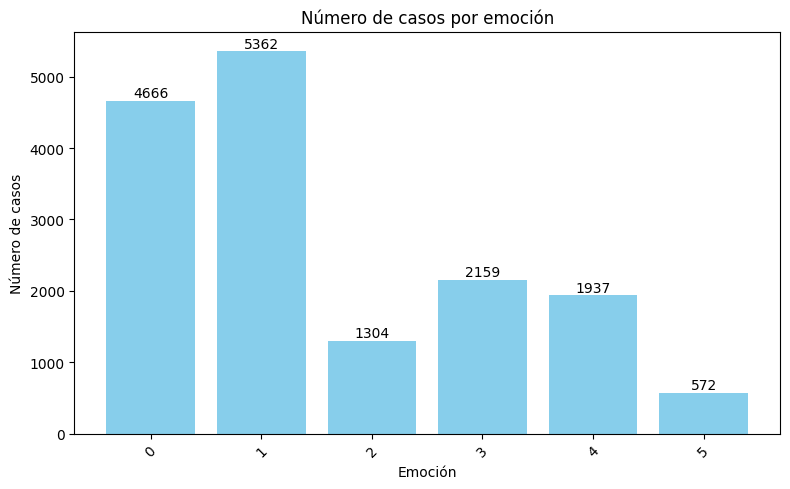

In [17]:
# Contar la frecuencia de cada etiqueta
from collections import Counter
emotion_counts = Counter(labels)

# Visualizar con un gráfico de barras con los valores exactos
plt.figure(figsize=(8, 5))
emotions = list(emotion_counts.keys())
counts = list(emotion_counts.values())

bars = plt.bar(emotions, counts, color='skyblue')

# Añadir los valores exactos sobre cada barra
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 5,
             f'{height}', ha='center', va='bottom')

plt.title('Número de casos por emoción')
plt.xlabel('Emoción')
plt.ylabel('Número de casos')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Distribución original de clases:
Clase 0: 4666 ejemplos
Clase 1: 5362 ejemplos
Clase 2: 1304 ejemplos
Clase 3: 2159 ejemplos
Clase 4: 1937 ejemplos
Clase 5: 572 ejemplos

Clase 2: añadiendo 2608 ejemplos (de 1304 a 3912)

Clase 3: añadiendo 1079 ejemplos (de 2159 a 3238)

Clase 4: añadiendo 968 ejemplos (de 1937 a 2905)

Clase 5: añadiendo 2002 ejemplos (de 572 a 2574)

Nueva distribución de clases:
Clase 0: 4666 ejemplos
Clase 1: 5362 ejemplos
Clase 2: 3912 ejemplos
Clase 3: 3238 ejemplos
Clase 4: 2905 ejemplos
Clase 5: 2574 ejemplos


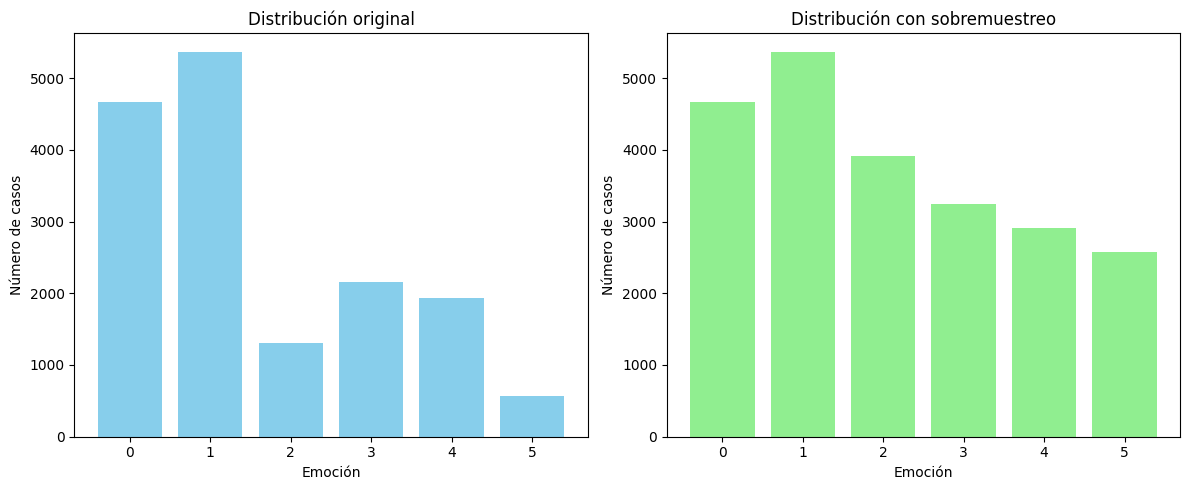

In [43]:
import numpy as np
import matplotlib.pyplot as plt
import random
from collections import Counter

def oversample_minority_classes(tweets, labels):
    """
    Realiza sobremuestreo de clases con diferentes multiplicadores:
    - Clase 5 (sorpresa): multiplicador = 4 (cuadruplicar)
    - Clase 2 (amor): multiplicador = 2 (duplicar)
    - Clases 3 y 4 (ira y miedo): multiplicador = 1.5 (aumentar 50%)
    - Clases 0 y 1: mantener igual

    Args:
        tweets: Lista de tweets
        labels: Lista de etiquetas

    Returns:
        Nuevas listas de tweets y etiquetas con las clases sobremuestreadas
    """
    # Convertir a arrays numpy para facilitar indexación
    tweets_array = np.array(tweets)
    labels_array = np.array(labels)

    # Contar ejemplos por clase
    class_counts = Counter(labels_array)
    print("Distribución original de clases:")
    for clase, count in sorted(class_counts.items()):
        print(f"Clase {clase}: {count} ejemplos")

    # Crear listas para los nuevos datos
    new_tweets = tweets.copy()
    new_labels = labels.copy()

    # Definir multiplicadores específicos por clase
    class_multipliers = {
        2: 3.0,   # Duplicar amor (cambiado de triplicar a duplicar)
        3: 1.5,   # Aumentar ira en 50%
        4: 1.5,   # Aumentar miedo en 50%
        5: 4.5    # Cuadruplicar sorpresa
    }

    # Sobremuestrear cada clase según su multiplicador
    for target_class, multiplier in class_multipliers.items():
        # Encontrar índices de la clase objetivo
        indices = np.where(labels_array == target_class)[0]
        current_count = len(indices)

        # Calcular cuántos ejemplos nuevos necesitamos
        target_count = int(current_count * multiplier)
        samples_needed = target_count - current_count

        print(f"\nClase {target_class}: añadiendo {samples_needed} ejemplos (de {current_count} a {target_count})")

        # Duplicar ejemplos aleatoriamente hasta alcanzar el objetivo
        for _ in range(samples_needed):
            # Seleccionar un ejemplo aleatorio de la clase objetivo
            idx = random.choice(indices)

            # Añadir a las nuevas listas
            new_tweets.append(tweets[idx])
            new_labels.append(target_class)

    # Verificar la nueva distribución
    new_class_counts = Counter(new_labels)
    print("\nNueva distribución de clases:")
    for clase, count in sorted(new_class_counts.items()):
        print(f"Clase {clase}: {count} ejemplos")

    # Visualizar la distribución antes y después
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
    plt.title('Distribución original')
    plt.xlabel('Emoción')
    plt.ylabel('Número de casos')

    plt.subplot(1, 2, 2)
    plt.bar(new_class_counts.keys(), new_class_counts.values(), color='lightgreen')
    plt.title('Distribución con sobremuestreo')
    plt.xlabel('Emoción')
    plt.ylabel('Número de casos')

    plt.tight_layout()
    plt.show()

    return new_tweets, new_labels

# Obtener datos de validación
val_tweets, val_labels = get_tweets(val)
val_sequences = get_sequences(tokenizer, val_tweets)
val_labels = np.array(val_labels)  # Asumiendo que ya son valores numéricos

# Aplicar el sobremuestreo a los datos de entrenamiento con los nuevos multiplicadores
new_tweets, new_labels = oversample_minority_classes(tweets, labels)

# Obtener secuencias para los nuevos tweets
new_padded_train_sequences = get_sequences(tokenizer, new_tweets)

# Como los labels ya son numéricos (0-5), convertimos directamente a array
new_train_labels = np.array(new_labels)

## **CREACIÓN DEL MODELO**

Ahora construimos nuestro modelo de aprendizaje profundo para detectar emociones en los tweets. Utilizamos una arquitectura secuencial donde cada capa alimenta a la siguiente. Comenzamos con una capa de Embedding que transforma nuestros índices de palabras en vectores densos de 16 dimensiones, capturando relaciones semánticas entre ellas. Luego añadimos dos capas LSTM bidireccionales, que leen los tweets en ambas direcciones para entender mejor el contexto completo de cada palabra. La primera capa LSTM devuelve secuencias completas para alimentar a la segunda, mientras que la segunda proporciona una representación condensada del tweet. Finalmente, conectamos todo a una capa densa con 6 neuronas (una por cada emoción) y función de activación softmax, que nos dará probabilidades para cada categoría emocional. Compilamos nuestro modelo usando el optimizador Adam y una función de pérdida adecuada para clasificación, definiendo la precisión como nuestra métrica principal. Al solicitar un resumen, podemos verificar la estructura completa de nuestro modelo antes de entrenarlo.

Epoch 1/20
709/709 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.3578 - loss: 1.5168 - val_accuracy: 0.7925 - val_loss: 0.6210
Epoch 2/20
709/709 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.8702 - loss: 0.4284 - val_accuracy: 0.8545 - val_loss: 0.4578
Epoch 3/20
709/709 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.9302 - loss: 0.2321 - val_accuracy: 0.8695 - val_loss: 0.4127
Epoch 4/20
709/709 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.9524 - loss: 0.1638 - val_accuracy: 0.8765 - val_loss: 0.3980
Epoch 5/20
709/709 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.9706 - loss: 0.1072 - val_accuracy: 0.8805 - val_loss: 0.4153
Epoch 6/20
709/709 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.9737 - loss: 0.0960 - val_accuracy: 0.8765 - val_loss: 0.4501
Epoch 7/20
709/709 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.9760 - loss: 0.0877 - val_accuracy: 0.8830 - val_loss: 0.4259
Epoch 8/20
709/709 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.9830 - loss: 0.0623 - v

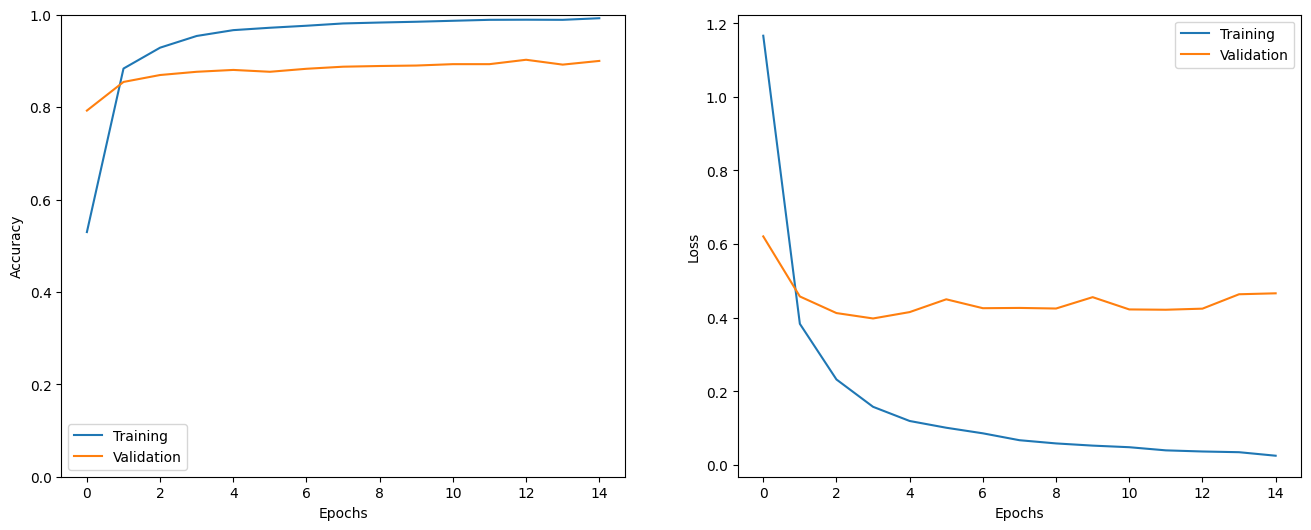

In [44]:
# Entrenar el modelo con los datos balanceados
balanced_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(10000, 16),  # Quité input_length para evitar la advertencia
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
    tf.keras.layers.Dense(6, activation='softmax')
])

balanced_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# Entrenar con los datos balanceados
h_balanced = balanced_model.fit(
    new_padded_train_sequences, new_train_labels,
    validation_data=(val_sequences, val_labels),
    epochs=20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)
    ]
)

# Comparar el rendimiento
show_history(h_balanced)

## **EVALUACIÓN DEL MODELO**

Finalmente evaluamos nuestro modelo balanceado de clasificación de emociones sobre el conjunto de prueba. Primero prepara los datos convirtiéndolos al formato requerido y define un diccionario que traduce los índices numéricos a nombres de emociones en español. Luego procede a evaluar el desempeño global del modelo, muestra un ejemplo aleatorio de predicción para verificación visual, y genera un análisis completo de rendimiento que incluye el informe de clasificación con métricas detalladas (precisión, recall, F1) para cada emoción. Finalmente, visualiza la matriz de confusión mediante un mapa de calor para identificar patrones de error entre clases, y muestra una tabla con ejemplos aleatorios de predicciones que nos permite examinar casos específicos donde el modelo acierta o falla, facilitando el análisis cualitativo de su comportamiento.

In [45]:
# Preparar datos de prueba
test_tweets, test_labels = get_tweets(test)
test_sequences = get_sequences(tokenizer, test_tweets)
# Convertir directamente a array numpy si ya son índices numéricos (0-5)
test_labels = np.array(test_labels)

# Diccionario para interpretación en español
EMOTION_NAMES_ES = {
    0: "tristeza",
    1: "alegría",
    2: "amor",
    3: "ira",
    4: "miedo",
    5: "sorpresa"
}

# Evaluar el modelo balanceado
print("Evaluación en el conjunto de prueba:")
_ = balanced_model.evaluate(test_sequences, test_labels)

Evaluación en el conjunto de prueba:
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8842 - loss: 0.5061


In [46]:
# Mostrar una predicción aleatoria
i = random.randint(0, len(test_labels) - 1)

print('\nTweet:', test_tweets[i])
print('Emoción real:', EMOTION_NAMES_ES[test_labels[i]])

p = np.argmax(balanced_model.predict(np.expand_dims(test_sequences[i], axis=0)), axis=1)[0]

print('Emoción predicha:', EMOTION_NAMES_ES.get(p))
print('¿Predicción correcta?:', "Acertó" if p == test_labels[i] else "Falló")


Tweet: i feel ashamed of you
Emoción real: tristeza
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step
Emoción predicha: tristeza
¿Predicción correcta?: Acertó


In [47]:
# Obtener todas las predicciones
preds = np.argmax(balanced_model.predict(test_sequences), axis=1)
print("\nForma de predicciones:", preds.shape)
print("Forma de etiquetas de prueba:", test_labels.shape)

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

Forma de predicciones: (2000,)
Forma de etiquetas de prueba: (2000,)


In [48]:
# Evaluar y mostrar métricas
from sklearn.metrics import classification_report

print("\nInforme de clasificación:")
print(classification_report(test_labels, preds,
                          target_names=[EMOTION_NAMES_ES[i] for i in range(6)]))


Informe de clasificación:
              precision    recall  f1-score   support

    tristeza       0.94      0.94      0.94       581
     alegría       0.91      0.91      0.91       695
        amor       0.74      0.77      0.75       159
         ira       0.91      0.85      0.88       275
       miedo       0.87      0.88      0.88       224
    sorpresa       0.72      0.82      0.77        66

    accuracy                           0.89      2000
   macro avg       0.85      0.86      0.85      2000
weighted avg       0.90      0.89      0.89      2000



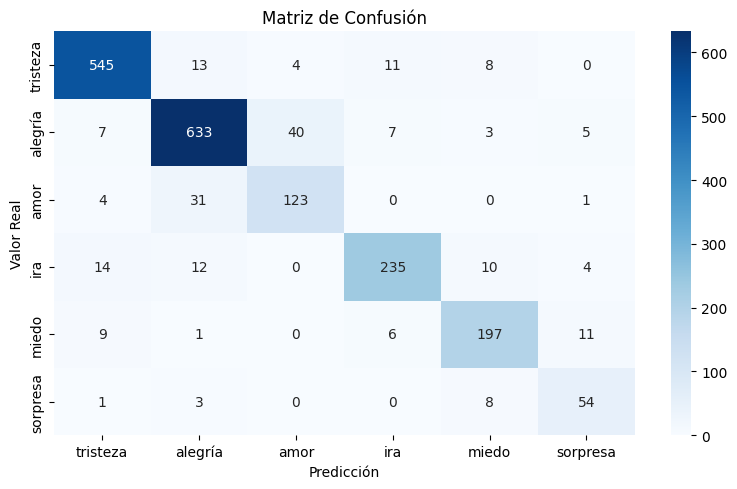


Métricas por Emoción:
tristeza        - Precisión: 0.9397, Recall: 0.9380
alegría         - Precisión: 0.9134, Recall: 0.9108
amor            - Precisión: 0.7365, Recall: 0.7736
ira             - Precisión: 0.9073, Recall: 0.8545
miedo           - Precisión: 0.8717, Recall: 0.8795
sorpresa        - Precisión: 0.7200, Recall: 0.8182

Precisión Global: 0.8935
Precisión promedio: 0.8481
Recall promedio: 0.8624
F1-Score promedio: 0.8552


In [49]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def enhanced_confusion_matrix(y_true, y_pred, class_indices_to_names):
    # Asegurarnos de que los nombres de clases son cadenas
    class_names = [str(class_indices_to_names[i]) for i in sorted(class_indices_to_names.keys())]

    # Crear la matriz de confusión
    cm = confusion_matrix(y_true, y_pred)

    # Configurar el tamaño de la figura
    plt.figure(figsize=(8, 5))

    # Crear un mapa de calor con seaborn
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

    # Añadir etiquetas y título
    plt.xlabel('Predicción')
    plt.ylabel('Valor Real')
    plt.title('Matriz de Confusión')

    # Ajustar el diseño
    plt.tight_layout()
    plt.show()

    # Calcular y mostrar métricas por clase
    print("\nMétricas por Emoción:")
    precision_per_class = np.diag(cm) / np.sum(cm, axis=0)
    recall_per_class = np.diag(cm) / np.sum(cm, axis=1)

    for i, class_name in enumerate(class_names):
        print(f"{class_name:15} - Precisión: {precision_per_class[i]:.4f}, Recall: {recall_per_class[i]:.4f}")

    # Calcular y mostrar la precisión global
    accuracy = np.sum(np.diag(cm)) / np.sum(cm)
    print(f"\nPrecisión Global: {accuracy:.4f}")

    # Mostrar más métricas globales
    total_precision = np.mean(precision_per_class)
    total_recall = np.mean(recall_per_class)
    f1_score = 2 * (total_precision * total_recall) / (total_precision + total_recall)

    print(f"Precisión promedio: {total_precision:.4f}")
    print(f"Recall promedio: {total_recall:.4f}")
    print(f"F1-Score promedio: {f1_score:.4f}")

# Utilizar nuestro diccionario en español
enhanced_confusion_matrix(test_labels, preds, EMOTION_NAMES_ES)

In [50]:
# Función para mostrar ejemplos de predicciones en un DataFrame
import pandas as pd

def display_predictions_sample(test_tweets, test_labels, predictions, n=15):
    # Seleccionar n ejemplos aleatorios
    if len(test_tweets) > n:
        sample_indices = random.sample(range(len(test_tweets)), n)
    else:
        sample_indices = range(len(test_tweets))

    # Crear listas para almacenar los datos
    tweets = []
    pred_indices = []
    true_indices = []
    pred_emotions = []
    true_emotions = []
    is_correct = []

    # Recopilar datos para cada ejemplo
    for idx in sample_indices:
        tweet = test_tweets[idx]
        true_label = test_labels[idx]
        pred_label = predictions[idx]

        # Obtener nombres de emociones en español
        true_emotion = EMOTION_NAMES_ES.get(true_label, "Desconocido")
        pred_emotion = EMOTION_NAMES_ES.get(pred_label, "Desconocido")

        # Guardar los datos
        tweets.append(tweet)
        pred_indices.append(int(pred_label))
        true_indices.append(int(true_label))
        pred_emotions.append(pred_emotion)
        true_emotions.append(true_emotion)
        # Usar "Acertó" o "Falló" en español
        is_correct.append("Acertó" if pred_label == true_label else "Falló")

    # Crear el DataFrame
    df = pd.DataFrame({
        'Tweet': tweets,
        'Predicción (índice)': pred_indices,
        'Verdadero (índice)': true_indices,
        'Emoción Predicha': pred_emotions,
        'Emoción Verdadera': true_emotions,
        'Resultado': is_correct
    })

    return df

# Mostrar una muestra de predicciones
print("\nMuestra de predicciones:")
predictions_df = display_predictions_sample(test_tweets, test_labels, preds, n=15)
predictions_df


Muestra de predicciones:


,Tweet,Predicción (índice),Verdadero (índice),Emoción Predicha,Emoción Verdadera,Resultado
0,i feel a bit dazed but so excited i am going t...,5,5,sorpresa,sorpresa,Acertó
1,im feeling a little lethargic,0,0,tristeza,tristeza,Acertó
2,i told my fiance how i am feeling so angry and...,3,3,ira,ira,Acertó
3,i feel more of numb now,0,0,tristeza,tristeza,Acertó
4,i have been feeling so melancholy and alone,0,0,tristeza,tristeza,Acertó
5,i feel like being all stubborn and stingy,3,3,ira,ira,Acertó
6,i think or feel but like this person i am stil...,5,5,sorpresa,sorpresa,Acertó
7,i feel kind of awkward about doing this here goes,0,0,tristeza,tristeza,Acertó
8,im feeling envious already,3,3,ira,ira,Acertó
9,ive been feeling afraid a lot lately,4,4,miedo,miedo,Acertó


# **CONCLUSIÓN**

Nuestro modelo de clasificación de emociones alcanza un destacado rendimiento global del 89% de exactitud en el conjunto de prueba, demostrando gran capacidad para identificar correctamente las seis emociones analizadas. Las emociones mayoritarias (tristeza, alegría e ira) presentan excelentes métricas con F1-scores entre 0.88-0.94, mientras que las emociones minoritarias, tradicionalmente más difíciles de detectar, también alcanzan resultados robustos con F1-scores de 0.75-0.88. La matriz de confusión revela patrones coherentes con la semántica de las emociones: principalmente confusión entre amor-alegría (emociones positivas) y sorpresa-miedo (reacciones súbitas). El modelo logra un notable equilibrio entre precision y recall incluso en clases desbalanceadas como sorpresa (66 ejemplos), gracias a nuestra estrategia optimizada de sobremuestreo. Estos resultados posicionan al sistema como una herramienta confiable para aplicaciones de análisis emocional en contenido generado por usuarios en redes sociales.